In [ ]:
import torch
from torch import nn
from torchsummary import summary
import hc_utils as utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
import time

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
data = utils.load_data('./data/heat_cond_data_n32_new.pickle', normalize=True)
test_data = utils.load_data('./data/heat_cond_data_n64.pickle', normalize=True)

In [ ]:
train_loader, test_loader = utils.get_data_loaders(data, test_size=0.5, batch_size=128, training_noise=None)

In [ ]:
len(train_loader.dataset), len(test_loader.dataset)

(1024, 1024)

# MLP approach

In [ ]:
class FCN(nn.Module):
    def __init__(self, in_features=32*32*2, out_features=4, layers_sizes=[256,256], bn=False, af=nn.ReLU(), transform_output=False):
        super().__init__()

        self.layers = nn.ModuleList()

        for l in layers_sizes:
            self.layers.append(nn.Linear(in_features=in_features, out_features=l))
            in_features = l
            if bn:
                self.layers.append(nn.BatchNorm1d(num_features = in_features))

            self.layers.append(af)

        self.layers.append(nn.Linear(in_features=in_features, out_features=out_features))
        
        self.transform_output = transform_output

    def forward(self, x):
        y = torch.flatten(x, start_dim=1)

        for layer in self.layers:
            y = layer(y)

        if self.transform_output:
            y = nn.functional.sigmoid(y)

        return y

In [ ]:
summary(FCN(bn=True), (2,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         524,544
       BatchNorm1d-2                  [-1, 256]             512
              ReLU-3                  [-1, 256]               0
            Linear-4                  [-1, 256]          65,792
       BatchNorm1d-5                  [-1, 256]             512
              ReLU-6                  [-1, 256]               0
            Linear-7                    [-1, 4]           1,028
Total params: 592,388
Trainable params: 592,388
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.01
Params size (MB): 2.26
Estimated Total Size (MB): 2.28
----------------------------------------------------------------


In [ ]:
criterion = nn.MSELoss()
fcn = FCN(layers_sizes=[128,128,128], bn=False, af=nn.ReLU()).double()
sgd = torch.optim.SGD(fcn.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-3)

In [ ]:
n_epoch = 1500
fcn = FCN(layers_sizes=[128,128], bn=False, af=nn.ReLU()).double()
sgd = torch.optim.SGD(fcn.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-3)
train_losses, valid_losses, _ = utils.train_model(fcn, train_loader, test_loader, criterion, sgd, device, n_epoch, early_stop=True, patience=30)

Epochs:  49%|██████████████████████████████████▋                                    | 734/1500 [00:56<00:58, 13.04it/s]


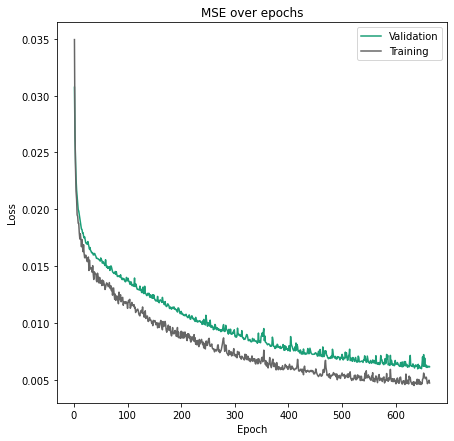

In [ ]:
utils.plot_loss(train_losses, valid_losses, start=2, end=None, filename='mlp_relu.png')

In [ ]:
ev = utils.Evaluator(fcn, dataset=test_loader.dataset.data)
ev.calculate_loss()

0.006379065960298786

In [ ]:
test_fcn = nn.Sequential(
    nn.AvgPool2d(kernel_size=2, stride=2),
    fcn
)

test_ev2 = utils.Evaluator(test_fcn, dataset=test_data)
test_ev2.calculate_loss()

0.009285282272430013

true: [0.453125 0.359375 0.765625 0.09375 ]
prediction: [0.3772533  0.39306961 0.78724838 0.10495107]


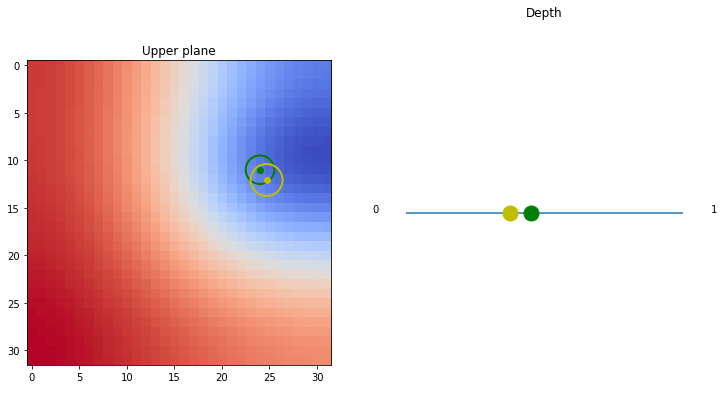

In [ ]:
ev.plot_next()

In [ ]:
afs = [('Tanh',nn.Tanh()), ('Sigmoid',nn.Sigmoid()), ('ReLU',nn.ReLU()), ('LReLU', nn.LeakyReLU(negative_slope=0.2))]
sigmoids = [False, True]
bns = [False, True]

In [ ]:
n_epoch = 1500
results = []
for sigmoid in sigmoids:
    for bn in bns:
        for af_name, af in afs:
            criterion = nn.MSELoss()
            fcn = FCN(layers_sizes=[256,256], bn=bn, af=af, transform_output=sigmoid).double()
            sgd = torch.optim.SGD(fcn.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-3)

            start_time = time.time()
            train_losses, valid_losses, _ = utils.train_model(fcn, train_loader, test_loader, criterion, sgd, device, n_epoch, early_stop=True, patience=20)
            end_time = time.time()

            results.append((af_name, bn, sigmoid, train_losses, valid_losses, end_time-start_time, sum(p.numel() for p in fcn.parameters())))

Epochs:  36%|█████████████████████████▊                                             | 545/1500 [01:08<02:00,  7.92it/s]


In [ ]:
df = pd.DataFrame(results, columns=['af', 'bn', 'sigmoid', 'train_losses', 'valid_losses', 'exec_time', 'n_params'])
df['epochs'] = df.valid_losses.apply(lambda x: len(x))
df['min_loss'] = df.valid_losses.apply(lambda x: np.min(x))
df['unit_time'] = df.exec_time / df.epochs
df

,af,bn,sigmoid,train_losses,valid_losses,exec_time,n_params,epochs,min_loss,unit_time
0,Tanh,False,False,"[0.15851572008639506, 0.048931482063728556, 0....","[0.07123767228496797, 0.03381293691839081, 0.0...",73.480021,591364,660,0.010299,0.111333
1,Sigmoid,False,False,"[0.1587862174334466, 0.07429598229519815, 0.05...","[0.0738679244407181, 0.05113509226004601, 0.05...",70.489054,591364,594,0.020391,0.118668
2,ReLU,False,False,"[0.11800287630251394, 0.05004516211511992, 0.0...","[0.07551834453267467, 0.04084133777894967, 0.0...",55.002912,591364,487,0.006373,0.112942
3,LReLU,False,False,"[0.14883118901204687, 0.05177680258991368, 0.0...","[0.05535396238100122, 0.033776031151629506, 0....",81.240329,591364,674,0.006695,0.120535
4,Tanh,True,False,"[0.17807506421330077, 0.047509034210424454, 0....","[0.09665348233960591, 0.0372019737171282, 0.03...",19.508477,592388,165,0.014742,0.118233
5,Sigmoid,True,False,"[0.25624024827078157, 0.0826698229468406, 0.04...","[0.06617046931415729, 0.04607970092765363, 0.0...",17.007585,592388,138,0.020106,0.123243
6,ReLU,True,False,"[0.11848902526290948, 0.047271977276959566, 0....","[0.08290635516777987, 0.04091168273397848, 0.0...",22.876817,592388,178,0.011026,0.128521
7,LReLU,True,False,"[0.10451917346506395, 0.04003997772300682, 0.0...","[0.06620864183649675, 0.03273725414194736, 0.0...",11.504328,592388,84,0.013089,0.136956
8,Tanh,False,True,"[0.08896515391224254, 0.07192619334646846, 0.0...","[0.08024298036604825, 0.06575853465449957, 0.0...",171.899068,591364,1500,0.011574,0.114599
9,Sigmoid,False,True,"[0.0704804656777384, 0.04915063460585123, 0.04...","[0.05184866179764293, 0.04940116193227932, 0.0...",99.763792,591364,788,0.029077,0.126604


In [ ]:
df = pd.DataFrame(results2, columns=['af', 'bn', 'sigmoid', 'train_losses', 'valid_losses', 'exec_time', 'n_params'])
df['epochs'] = df.valid_losses.apply(lambda x: len(x))
df['min_loss'] = df.valid_losses.apply(lambda x: np.min(x))
df['unit_time'] = df.exec_time / df.epochs
df

,af,bn,sigmoid,train_losses,valid_losses,exec_time,n_params,epochs,min_loss,unit_time
0,Tanh,False,False,"[0.15782220514412715, 0.04831120843995066, 0.0...","[0.0713755130430441, 0.03504684225820443, 0.02...",203.149423,279300,944,0.009200,0.215201
1,Sigmoid,False,False,"[0.17786815722167182, 0.08372693487025627, 0.0...","[0.07451590496487667, 0.05816368026133466, 0.0...",293.484200,279300,1268,0.017268,0.231454
2,ReLU,False,False,"[0.11545901025141186, 0.04762567327323552, 0.0...","[0.05975095872989491, 0.037239864578336605, 0....",128.038925,279300,563,0.006136,0.227423
3,LReLU,False,False,"[0.14130541516205533, 0.04607140922414809, 0.0...","[0.050753829041744705, 0.0344321773003851, 0.0...",123.017013,279300,530,0.007990,0.232108
4,Tanh,True,False,"[0.16857484789378238, 0.05025698776664844, 0.0...","[0.09151100837301526, 0.034235582437114054, 0....",20.282818,279812,90,0.015721,0.225365
5,Sigmoid,True,False,"[0.11911909528275737, 0.05107189429616612, 0.0...","[0.04742950404109804, 0.050935899018259935, 0....",26.889812,279812,111,0.020527,0.242251
6,ReLU,True,False,"[0.1553593709327214, 0.04159778992507563, 0.02...","[0.05153125875618129, 0.04767508184889863, 0.0...",34.498730,279812,145,0.011746,0.237922
7,LReLU,True,False,"[0.12792163661984332, 0.04200335551813602, 0.0...","[0.053266620084412596, 0.038293829035181595, 0...",36.379822,279812,151,0.012640,0.240926


In [ ]:
n_epoch = 1500
results3 = []
for sigmoid in sigmoids:
    if not sigmoid:
        for bn in bns:
            for af_name, af in afs:
                criterion = nn.MSELoss()
                fcn = FCN(layers_sizes=[128,128,128], bn=bn, af=af, transform_output=sigmoid).double()
                sgd = torch.optim.SGD(fcn.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-3)

                start_time = time.time()
                train_losses, valid_losses = train_model(fcn, train_loader, test_loader, criterion, sgd, device, n_epoch, early_stop=True, patience=20)
                end_time = time.time()

                results3.append((af_name, bn, sigmoid, train_losses, valid_losses, end_time-start_time, sum(p.numel() for p in fcn.parameters())))

Epochs:  45%|████████████████████████████████▏                                      | 681/1500 [00:58<01:10, 11.66it/s]


In [ ]:
df = pd.DataFrame(results3, columns=['af', 'bn', 'sigmoid', 'train_losses', 'valid_losses', 'exec_time', 'n_params'])
df['epochs'] = df.valid_losses.apply(lambda x: len(x))
df['min_loss'] = df.valid_losses.apply(lambda x: np.min(x))
df['unit_time'] = df.exec_time / df.epochs
df

,af,bn,sigmoid,train_losses,valid_losses,exec_time,n_params,epochs,min_loss,unit_time
0,Tanh,False,False,"[0.16652990627677827, 0.04408003780066012, 0.0...","[0.07064231554977499, 0.03568414121325873, 0.0...",54.905574,295812,720,0.010135,0.076258
1,Sigmoid,False,False,"[0.10013880160560897, 0.0633159528754904, 0.05...","[0.05944671554915052, 0.0528486692426096, 0.05...",29.586356,295812,355,0.029739,0.083342
2,ReLU,False,False,"[0.22312303779717815, 0.062388842589101275, 0....","[0.1015767391313167, 0.05134142973924629, 0.03...",54.131233,295812,679,0.005982,0.079722
3,LReLU,False,False,"[0.20083694810350064, 0.05579306024746086, 0.0...","[0.08191779320315065, 0.052588942990717126, 0....",58.415635,295812,682,0.007475,0.085653


In [ ]:
df1 = pd.DataFrame(results, columns=['af', 'bn', 'sigmoid', 'train_losses', 'valid_losses', 'exec_time', 'n_params'])
df2 = pd.DataFrame(results2, columns=['af', 'bn', 'sigmoid', 'train_losses', 'valid_losses', 'exec_time', 'n_params'])
df3 = pd.DataFrame(results3, columns=['af', 'bn', 'sigmoid', 'train_losses', 'valid_losses', 'exec_time', 'n_params'])

In [ ]:
df1['depth'] = 2
df1['width'] = 256
df2['depth'] = 2
df2['width'] = 128
df3['depth'] = 3
df3['width'] = 128

In [ ]:
df = pd.concat([df1, df2, df3])
df = df[(df['sigmoid'] == False)&(df['bn'] == False)]
df['epochs'] = df.valid_losses.apply(lambda x: len(x))
df['min_loss'] = df.valid_losses.apply(lambda x: np.min(x))
df['unit_time'] = df.exec_time / df.epochs
df

,af,bn,sigmoid,train_losses,valid_losses,exec_time,n_params,depth,width,epochs,min_loss,unit_time
0,Tanh,False,False,"[0.17981939752977746, 0.05032275425044493, 0.0...","[0.07702602834983255, 0.03318720384138642, 0.0...",71.365721,591364,2,256,644,0.010423,0.110816
1,Sigmoid,False,False,"[0.15229266200311883, 0.07158465998064972, 0.0...","[0.057044222940540915, 0.05686037766881276, 0....",79.204376,591364,2,256,662,0.019945,0.119644
2,ReLU,False,False,"[0.12918778453359292, 0.046405317637554656, 0....","[0.06297024770319716, 0.03665541951487268, 0.0...",61.684082,591364,2,256,533,0.006061,0.115730
3,LReLU,False,False,"[0.14672472535731862, 0.04640654663119611, 0.0...","[0.05043349326103116, 0.0355459644035629, 0.02...",68.830203,591364,2,256,546,0.007235,0.126063
0,Tanh,False,False,"[0.1918139657966401, 0.05723771321300084, 0.03...","[0.0908567634805552, 0.035855735470885455, 0.0...",51.622066,279300,2,128,732,0.010108,0.070522
1,Sigmoid,False,False,"[0.124715257277019, 0.07047105935404292, 0.049...","[0.05847028841152598, 0.06037694086539332, 0.0...",81.657403,279300,2,128,1056,0.017916,0.077327
2,ReLU,False,False,"[0.14020447756193952, 0.049289601588489086, 0....","[0.0541498415848715, 0.03704290909893427, 0.03...",36.642948,279300,2,128,481,0.006448,0.076181
3,LReLU,False,False,"[0.13528984372714595, 0.04636822291792311, 0.0...","[0.050730052071811305, 0.03372244553128514, 0....",41.031830,279300,2,128,538,0.007838,0.076267
0,Tanh,False,False,"[0.16652990627677827, 0.04408003780066012, 0.0...","[0.07064231554977499, 0.03568414121325873, 0.0...",54.905574,295812,3,128,720,0.010135,0.076258
1,Sigmoid,False,False,"[0.10013880160560897, 0.0633159528754904, 0.05...","[0.05944671554915052, 0.0528486692426096, 0.05...",29.586356,295812,3,128,355,0.029739,0.083342


In [ ]:
df = df.sort_values(by='min_loss')
df_p = df[['depth', 'width', 'af', 'n_params', 'epochs', 'unit_time', 'min_loss']]
df_p

,depth,width,af,n_params,epochs,unit_time,min_loss
2,3,128,ReLU,295812,679,0.079722,0.005982
2,2,256,ReLU,591364,533,0.115730,0.006061
2,2,128,ReLU,279300,481,0.076181,0.006448
3,2,256,LReLU,591364,546,0.126063,0.007235
3,3,128,LReLU,295812,682,0.085653,0.007475
3,2,128,LReLU,279300,538,0.076267,0.007838
0,2,128,Tanh,279300,732,0.070522,0.010108
0,3,128,Tanh,295812,720,0.076258,0.010135
0,2,256,Tanh,591364,644,0.110816,0.010423
1,2,128,Sigmoid,279300,1056,0.077327,0.017916


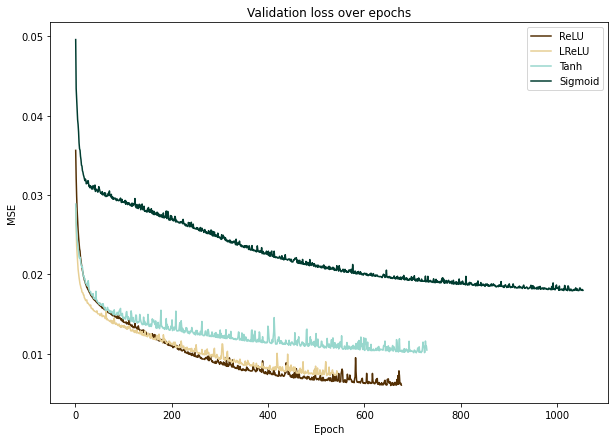

In [ ]:
start = 2
valid_losses1 = df.iloc[0]['valid_losses']
valid_losses2 = df.iloc[3]['valid_losses']
valid_losses3 = df.iloc[6]['valid_losses']
valid_losses4 = df.iloc[9]['valid_losses']
    
_, ax = plt.subplots(1,1,figsize=(10,7))

x1 = np.arange(len(valid_losses1[start:]))+1
x2 = np.arange(len(valid_losses2[start:]))+1
x3 = np.arange(len(valid_losses3[start:]))+1
x4 = np.arange(len(valid_losses4[start:]))+1

ax.set_title('Validation loss over epochs')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE')

colors = plt.cm.BrBG(np.linspace(0, 1, 4))

ax.plot(x1, valid_losses1[start:], label='ReLU', color=colors[0])
ax.plot(x2, valid_losses2[start:], label='LReLU', color=colors[1])
ax.plot(x3, valid_losses3[start:], label='Tanh', color=colors[2])
ax.plot(x4, valid_losses4[start:], label='Sigmoid', color=colors[3])


ax.legend()
plt.savefig('mlp_mse')
plt.show()

In [ ]:
df_p['unit_time'] = np.round(df_p['unit_time'], 3)
df_p['min_loss'] = np.round(df_p['min_loss'], 4)
df_p

<ipython-input-99-69a60bf9fb38>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_p['unit_time'] = np.round(df_p['unit_time'], 3)
<ipython-input-99-69a60bf9fb38>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_p['min_loss'] = np.round(df_p['min_loss'], 4)


,depth,width,af,n_params,epochs,unit_time,min_loss
2,3,128,ReLU,295812,679,0.080,0.0060
2,2,256,ReLU,591364,533,0.116,0.0061
2,2,128,ReLU,279300,481,0.076,0.0064
3,2,256,LReLU,591364,546,0.126,0.0072
3,3,128,LReLU,295812,682,0.086,0.0075
3,2,128,LReLU,279300,538,0.076,0.0078
0,2,128,Tanh,279300,732,0.071,0.0101
0,3,128,Tanh,295812,720,0.076,0.0101
0,2,256,Tanh,591364,644,0.111,0.0104
1,2,128,Sigmoid,279300,1056,0.077,0.0179


# Convolutional approach

In [ ]:
class ConvNet(nn.Module):
    def __init__(self, in_channels=2, out_features=4, bn=False, af=nn.ReLU(), transform_output=False):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=4, kernel_size=3, padding='same', padding_mode='reflect'),
            nn.BatchNorm2d(num_features=4),
            af,
            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, padding='same', padding_mode='reflect'),
            nn.BatchNorm2d(num_features=8),
            af,
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding='same', padding_mode='reflect'),
            nn.BatchNorm2d(num_features=16),
            af,
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding='same', padding_mode='reflect'),
            nn.BatchNorm2d(num_features=32),
            af,
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same', padding_mode='reflect'),
            nn.BatchNorm2d(num_features=64),
            af,
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding='same', padding_mode='reflect'),
            nn.BatchNorm2d(num_features=128),
            af,
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding='same', padding_mode='reflect'),
            nn.BatchNorm2d(num_features=256),
            af,
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=1)
        
        self.fc = nn.Linear(in_features=256, out_features=out_features)

        self.transform_output = transform_output
        
    def forward(self, x):
        y = self.conv(x)
        y = self.avgpool(y)
        y = torch.flatten(y, start_dim=1)
        y = self.fc(y)

        if self.transform_output:
            y = nn.functional.sigmoid(y)

        return y

In [ ]:
summary(ConvNet(), (2,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 32, 32]              76
       BatchNorm2d-2            [-1, 4, 32, 32]               8
              ReLU-3            [-1, 4, 32, 32]               0
            Conv2d-4            [-1, 8, 32, 32]             296
       BatchNorm2d-5            [-1, 8, 32, 32]              16
              ReLU-6            [-1, 8, 32, 32]               0
         MaxPool2d-7            [-1, 8, 16, 16]               0
            Conv2d-8           [-1, 16, 16, 16]           1,168
       BatchNorm2d-9           [-1, 16, 16, 16]              32
             ReLU-10           [-1, 16, 16, 16]               0
           Conv2d-11           [-1, 32, 16, 16]           4,640
      BatchNorm2d-12           [-1, 32, 16, 16]              64
             ReLU-13           [-1, 32, 16, 16]               0
        MaxPool2d-14             [-1, 3

In [ ]:
afs = [('ReLU',nn.ReLU()), ('LReLU', nn.LeakyReLU(negative_slope=0.2)), ('Tanh',nn.Tanh())]
sigmoids = [True, False]

In [ ]:
n_epoch = 1500
cresultstest = []
for sigmoid in sigmoids:
    for af_name, af in afs:
        criterion = nn.MSELoss()
        convnet = ConvNet(bn=True, af=af, transform_output=sigmoid).double()
        sgd = torch.optim.SGD(convnet.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-3)

        start_time = time.time()
        train_losses, valid_losses, model = utils.train_model(convnet, train_loader, test_loader, criterion, sgd, device, n_epoch, early_stop=True, patience=30)
        end_time = time.time()

        cresultstest.append((af_name, True, sigmoid, train_losses, valid_losses, end_time-start_time, sum(p.numel() for p in convnet.parameters())))

Epochs:  22%|███████████████▍                                                       | 326/1500 [14:06<50:46,  2.60s/it]


In [ ]:
cdftest = pd.DataFrame(cresultstest, columns=['af', 'bn', 'sigmoid', 'train_losses', 'valid_losses', 'exec_time', 'n_params'])
cdftest['epochs'] = cdftest.valid_losses.apply(lambda x: len(x))
cdftest['min_loss'] = cdftest.valid_losses.apply(lambda x: np.min(x))
cdftest['unit_time'] = cdftest.exec_time / cdftest.epochs
cdftest

,af,bn,sigmoid,train_losses,valid_losses,exec_time,n_params,epochs,min_loss,unit_time
0,ReLU,True,True,"[0.08286427588365733, 0.05401930267246571, 0.0...","[0.08343035057565157, 0.06598353972865537, 0.0...",846.020044,395744,327,0.000897,2.587217


In [ ]:
cdf = pd.DataFrame(cresultstest, columns=['af', 'bn', 'sigmoid', 'train_losses', 'valid_losses', 'exec_time', 'n_params'])

In [ ]:
cdf['epochs'] = cdf.valid_losses.apply(lambda x: len(x))
cdf['min_loss'] = cdf.valid_losses.apply(lambda x: np.min(x))
cdf['unit_time'] = cdf.exec_time / cdf.epochs
cdf

,af,bn,sigmoid,train_losses,valid_losses,exec_time,n_params,epochs,min_loss,unit_time
0,Tanh,True,False,"[0.1851047388433602, 0.05046032796727945, 0.02...","[0.18997623631355082, 0.06700865128391807, 0.1...",292.712491,395744,97,0.001085,3.017655
1,ReLU,True,False,"[0.10834828164201453, 0.04003603230057467, 0.0...","[0.05857554125420121, 0.0463885034178358, 0.02...",509.004701,395744,167,0.000854,3.047932
2,LReLU,True,False,"[0.14534476416171832, 0.04689668439916686, 0.0...","[0.053341817908313896, 0.0557850463759183, 0.0...",603.577671,395744,193,0.000883,3.127345
3,Tanh,True,True,"[0.07646859255606529, 0.050575554454322776, 0....","[0.09337351420841107, 0.07695969449066706, 0.0...",480.848087,395744,157,0.001582,3.062727
4,ReLU,True,True,"[0.06434675593873453, 0.037456673338280455, 0....","[0.07377596120974936, 0.052470214204725196, 0....",840.371446,395744,279,0.000710,3.012084
5,LReLU,True,True,"[0.07558034782094476, 0.04568678771009108, 0.0...","[0.07654668843164268, 0.05730005577977766, 0.0...",731.677356,395744,238,0.000759,3.074275


In [ ]:
cdf = cdf.sort_values(by='min_loss')
cdf_p = cdf[['af', 'sigmoid', 'n_params', 'epochs', 'unit_time', 'min_loss']]
cdf_p

,af,sigmoid,n_params,epochs,unit_time,min_loss
4,ReLU,True,395744,279,3.012084,0.000710
5,LReLU,True,395744,238,3.074275,0.000759
1,ReLU,False,395744,167,3.047932,0.000854
2,LReLU,False,395744,193,3.127345,0.000883
0,Tanh,False,395744,97,3.017655,0.001085
3,Tanh,True,395744,157,3.062727,0.001582


In [ ]:
cdf_p['unit_time'] = np.round(cdf_p['unit_time'], 3)
cdf_p['min_loss'] = np.round(cdf_p['min_loss'], 5)
cdf_p

<ipython-input-34-04bafa5ebdc7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf_p['unit_time'] = np.round(cdf_p['unit_time'], 3)
<ipython-input-34-04bafa5ebdc7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf_p['min_loss'] = np.round(cdf_p['min_loss'], 5)


,af,sigmoid,n_params,epochs,unit_time,min_loss
4,ReLU,True,395744,279,3.012,0.00071
5,LReLU,True,395744,238,3.074,0.00076
1,ReLU,False,395744,167,3.048,0.00085
2,LReLU,False,395744,193,3.127,0.00088
0,Tanh,False,395744,97,3.018,0.00108
3,Tanh,True,395744,157,3.063,0.00158


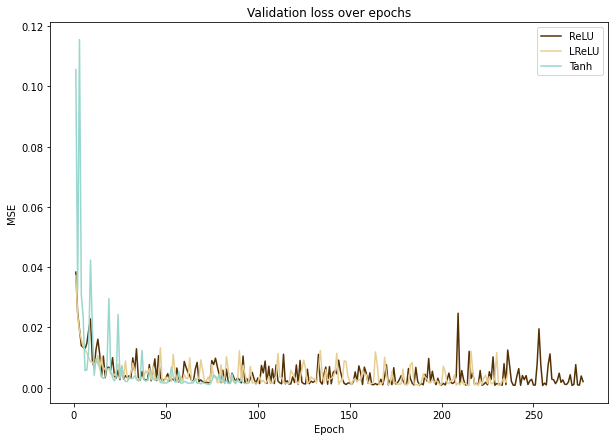

In [ ]:
start = 2
valid_losses1 = cdf.iloc[0]['valid_losses']
valid_losses2 = cdf.iloc[1]['valid_losses']
valid_losses3 = cdf.iloc[4]['valid_losses']
    
_, ax = plt.subplots(1,1,figsize=(10,7))

x1 = np.arange(len(valid_losses1[start:]))+1
x2 = np.arange(len(valid_losses2[start:]))+1
x3 = np.arange(len(valid_losses3[start:]))+1

ax.set_title('Validation loss over epochs')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE')

colors = plt.cm.BrBG(np.linspace(0, 1, 4))

ax.plot(x1, valid_losses1[start:], label='ReLU', color=colors[0])
ax.plot(x2, valid_losses2[start:], label='LReLU', color=colors[1])
ax.plot(x3, valid_losses3[start:], label='Tanh', color=colors[2])


ax.legend()
plt.savefig('conv_mse_new')
plt.show()

In [ ]:
n_epoch = 1500
criterion = nn.MSELoss()
convnet = ConvNet(bn=True, af=nn.ReLU(), transform_output=False).double()
sgd = torch.optim.SGD(convnet.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-3)

train_losses, valid_losses, convnet = train_model(convnet, train_loader, test_loader, criterion, sgd, device, n_epoch, early_stop=True, patience=30)

Epochs:  12%|████████                                                             | 176/1500 [08:52<1:06:42,  3.02s/it]


In [ ]:
np.min(valid_losses), valid_losses[-1]

(0.0008845511059950783, 0.0010286927727580616)

In [ ]:
convnet = torch.load('./models/convnet32_2.model')

In [ ]:
ev = utils.Evaluator(model, dataset=test_loader.dataset.data)
ev.calculate_loss()

0.0008971235549863725

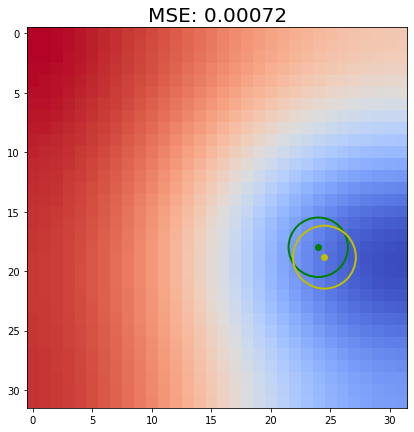

In [ ]:
ev.plot_average(avg=0.00071, filename='conv_pred4')

In [ ]:
test_ev = utils.Evaluator(model, dataset=test_data)
test_ev.calculate_loss()

0.07500632644663335

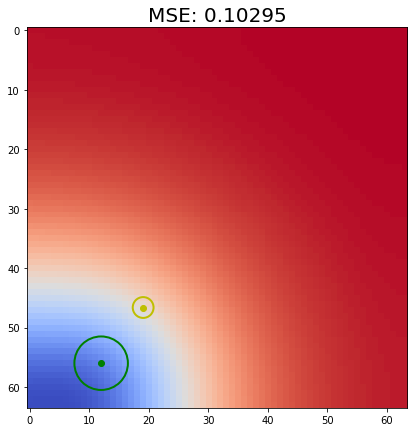

In [ ]:
test_ev.plot_average(avg=0.0937, tol=0.01, filename='conv_pred_test3')

In [ ]:
test_predictor = nn.Sequential(
    nn.AvgPool2d(kernel_size=2, stride=2),
    model
)

test_ev2 = utils.Evaluator(test_predictor, dataset=test_data)
test_ev2.calculate_loss()

0.023251016206711946

In [ ]:
torch.save(model, './models/convnet32_3.model')